In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Load the data

In [2]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [30]:
y.shape, tx.shape

((10000,), (10000, 2))

### NB: throughout this laboratory the data has the following format: 
  * there are **N = 10000** data entries
  * **y** represents the column vector containing weight information -- that which we wish to predict/the output (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,)**.
  * **tx** represents the matrix $\tilde{X}$ formed by laterally concatenating a column vector of 1s to the column vector of height information -- the input data (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,2)**.

# 1. Computing the Cost Function
Fill in the `compute_loss` function below:

In [7]:
def compute_loss(y, tx, w):
    """Calculate the loss using either MSE or MAE.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2,). The vector of model parameters.

    Returns:
        the value of the loss (a scalar), corresponding to the input parameters w.
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    nb_sample = y.shape[0]
    e = y - tx @ w
    return 1/(2*nb_sample) * e.T @ e
    # ***************************************************x

In [24]:
def compute_loss_MAE(y, tx, w):
    nb_sample = y.shape[0]
    e = y - tx @ w
    return 1/nb_sample * np.sum(np.abs(e))

# 2. Grid Search

Fill in the function `grid_search()` below:

In [3]:
# from costs import *


def grid_search(y, tx, grid_w0, grid_w1):
    """Algorithm for grid search.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        grid_w0: numpy array of shape=(num_grid_pts_w0, ). A 1D array containing num_grid_pts_w0 values of parameter w0 to be tested in the grid search.
        grid_w1: numpy array of shape=(num_grid_pts_w1, ). A 1D array containing num_grid_pts_w1 values of parameter w1 to be tested in the grid search.

    Returns:
        losses: numpy array of shape=(num_grid_pts_w0, num_grid_pts_w1). A 2D array containing the loss value for each combination of w0 and w1
    """

    losses = np.zeros((len(grid_w0), len(grid_w1)))
    # ***************************************************
    # INSERT YOUR CODE HERE
    w = np.hstack((grid_w0[:, np.newaxis], grid_w1[:, np.newaxis]))
    for i in range(len(grid_w0)):
        for j in range(len(grid_w1)):
            w = np.array([grid_w0[i], grid_w1[j]])
            losses[i, j] = compute_loss(y, tx, w)
            
    # ***************************************************
    return losses

In [4]:
# This function is a bit more efficient as it doesn't contain any for loop, but it is not possible to use the function compute_loss as
# we implemented it, because it expects to treat each (w0, w1) separately

# This one uses indices
def grid_search_v2(y, tx, grid_w0, grid_w1):
    row, col = np.indices((len(grid_w0), len(grid_w1)))
    big_w0, big_w1 = grid_w0[row.ravel()], grid_w1[col.ravel()]
    w = np.column_stack((big_w0, big_w1))
    e = (y[:, np.newaxis] - tx @ w.T)**2
    nb_sample = y.shape[0]
    losses = 1/(2*nb_sample) * np.sum(e, axis=0)
    return losses.reshape((len(grid_w0), len(grid_w1)))

In [5]:
# This one uses broadcasting, the broadcasting must be explicit, as we have to stack the arrays
def grid_search_v3(y, tx, grid_w0, grid_w1):
    w0_size, w1_size = grid_w0.shape[0], grid_w1.shape[0]
    w0 = np.broadcast_to(grid_w0[:, np.newaxis], (w0_size, w1_size))
    w1 = np.broadcast_to(grid_w1[np.newaxis, :], (w0_size, w1_size))
    w = np.column_stack((w0.ravel(), w1.ravel()))
    e = (y[:, np.newaxis] - tx @ w.T)**2
    nb_sample = y.shape[0]
    losses = 1/(2*nb_sample) * np.sum(e, axis=0)
    return losses.reshape((len(grid_w0), len(grid_w1)))

Let us play with the grid search demo now!

In [9]:
from grid_search import generate_w
grid_w0_t, grid_w1_t = generate_w(num_intervals=100)
%timeit -r 3 -n 3 -c grid_search(y, tx, grid_w0_t, grid_w1_t)
%timeit -r 3 -n 3 -c grid_search_v2(y, tx, grid_w0_t, grid_w1_t)
%timeit -r 3 -n 3 -c grid_search_v3(y, tx, grid_w0_t, grid_w1_t)

12.4 s ± 2.88 s per loop (mean ± std. dev. of 3 runs, 3 loops each)
6 s ± 164 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
6.12 s ± 121 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


Grid Search: loss*=15.428548387428156, w0*=73.57859531772576, w1*=13.545150501672254, execution time=5.519 seconds


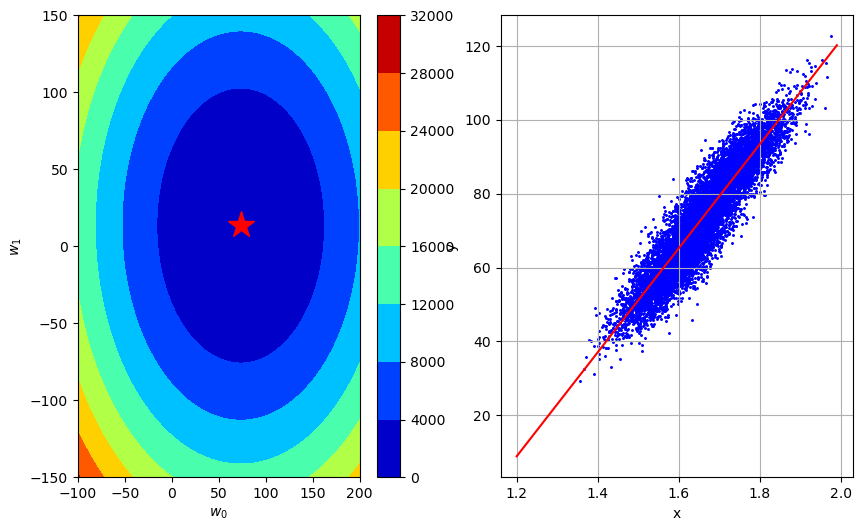

In [13]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

from grid_search import grid_search_v2

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=100)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search_v2(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print(
    "Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
        l=loss_star, w0=w0_star, w1=w1_star, t=execution_time
    )
)

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0, 6.0)
fig.savefig("grid_plot")  # Optional saving

# 3. Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [20]:
def compute_gradient(y, tx, w):
    """Computes the gradient at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        An numpy array of shape (2, ) (same shape as w), containing the gradient of the loss at w.
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    nb_sample = y.shape[0]
    e = y - tx @ w
    return -1/nb_sample * tx.T @ e
    # ***************************************************

Please fill in the functions `gradient_descent` below:

In [21]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """The Gradient Descent (GD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of GD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of GD
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: compute gradient and loss
        # ***************************************************
        loss = compute_loss(y, tx, w)
        gradient = compute_gradient(y, tx, w)
        # ***************************************************
        # INSERT YOUR CODE HERE
        w = w - gamma*gradient
        # ***************************************************

        # store w and loss
        ws.append(w)
        losses.append(loss)
        print(
            "GD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )

    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [22]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=2792.2367127591674, w0=51.30574540147361, w1=9.43579870449228
GD iter. 1/49: loss=265.3024621089606, w0=66.69746902191571, w1=12.266538315839998
GD iter. 2/49: loss=37.87837955044126, w0=71.31498610804834, w1=13.115760199244328
GD iter. 3/49: loss=17.41021212017447, w0=72.70024123388814, w1=13.37052676426563
GD iter. 4/49: loss=15.568077051450452, w0=73.11581777164007, w1=13.446956733772023
GD iter. 5/49: loss=15.402284895265302, w0=73.24049073296565, w1=13.469885724623941
GD iter. 6/49: loss=15.387363601208634, w0=73.27789262136334, w1=13.476764421879516
GD iter. 7/49: loss=15.386020684743531, w0=73.28911318788263, w1=13.478828031056189
GD iter. 8/49: loss=15.385899822261674, w0=73.29247935783842, w1=13.47944711380919
GD iter. 9/49: loss=15.385888944638305, w0=73.29348920882516, w1=13.47963283863509
GD iter. 10/49: loss=15.385887965652199, w0=73.29379216412119, w1=13.479688556082861
GD iter. 11/49: loss=15.38588787754345, w0=73.29388305071, w1=13.479705271317192
GD

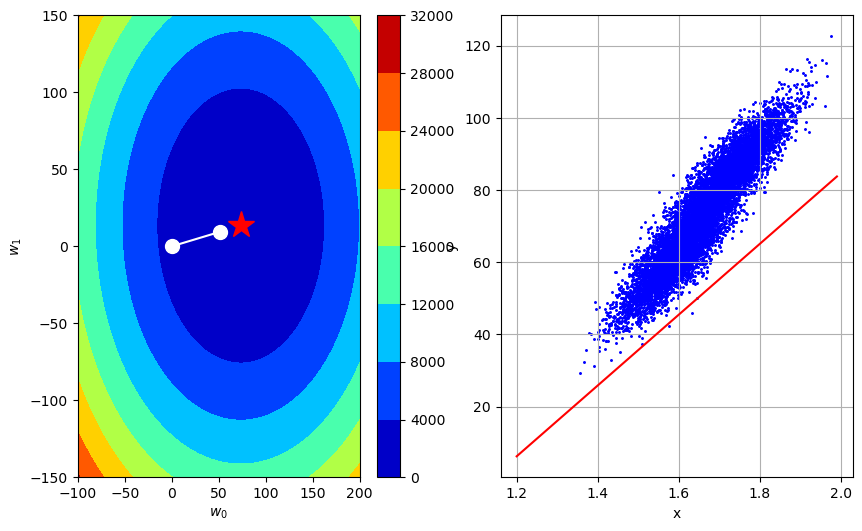

In [26]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)
    

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

# 4. Stochastic gradient descent

In [78]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient at w from a data sample batch of size B, where B < N, and their corresponding labels.

    Args:
        y: numpy array of shape=(B, )
        tx: numpy array of shape=(B,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the stochastic gradient of the loss at w.
    """

    # ***************************************************
    # INSERT YOUR CODE HERE
    nb_sample = y.shape[0]
    e = y - tx @ w
    return -1/nb_sample * tx.T @ e
    # ***************************************************


def stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """The Stochastic Gradient Descent algorithm (SGD).

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic gradient
        max_iters: a scalar denoting the total number of iterations of SGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w

    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: implement stochastic gradient descent.
        # ***************************************************
        loss = compute_loss(y, tx, w)
        gradient = np.zeros(tx.shape[1]) # init the gradient for the upcoming batch
        for y_batch, tx_batch in batch_iter(y,tx, batch_size):
            gradient += compute_stoch_gradient(y_batch, tx_batch, w)

        w = w - gamma * gradient/batch_size
        # store w and loss
        ws.append(w)
        losses.append(loss)
        # ***************************************************
        print(
            "SGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )
    return losses, ws

In [103]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD iter. 0/49: loss=2792.2367127591674, w0=5.68321294116898, w1=-7.039907321989116
SGD iter. 1/49: loss=2511.5172752155922, w0=14.225267620194348, w1=-1.2445104939420464
SGD iter. 2/49: loss=1868.3402235440758, w0=22.228471410358175, w1=8.513831515048441
SGD iter. 3/49: loss=1331.555996593422, w0=27.23331534324224, w1=8.10691154586556
SGD iter. 4/49: loss=1090.6091254571572, w0=32.32941117889554, w1=18.667302289862995
SGD iter. 5/49: loss=867.8870056124554, w0=36.236022769748715, w1=16.175189393581295
SGD iter. 6/49: loss=705.6626336437237, w0=40.43322232513989, w1=11.414964289237563
SGD iter. 7/49: loss=557.4302719513751, w0=43.238386258138036, w1=11.331147947689304
SGD iter. 8/49: loss=469.36166697531553, w0=46.608148341794085, w1=9.92888716313055
SGD iter. 9/49: loss=377.7553258491407, w0=48.543937082575475, w1=7.526406317061618
SGD iter. 10/49: loss=339.3876914941795, w0=51.87464332996305, w1=6.404630919853675
SGD iter. 11/49: loss=269.80702650917584, w0=52.917213158187714, w1=4.8

In [72]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses,
        sgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 5. Effect of Outliers and MAE Cost Function

In [112]:
import datetime
from helpers import *

# ***************************************************
# INSERT YOUR CODE HERE
# TODO: reload the data by subsampling first, then by subsampling and adding outliers
height, weight, gender = load_data(sub_sample=True, add_outlier=True)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)
# ***************************************************

x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [34]:
y.shape, tx.shape

((200,), (200, 2))

In [38]:
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()

# ***************************************************
# INSERT YOUR CODE HERE
# TODO: fit the model to the subsampled data / subsampled data with outliers and visualize the cloud of points
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
#       and the model fit
# ***************************************************


end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=2869.835114535854, w0=51.84746409844846, w1=7.724426406192428
GD iter. 1/49: loss=318.2821247015954, w0=67.40170332798299, w1=10.041754328050121
GD iter. 2/49: loss=88.6423556165127, w0=72.06797509684336, w1=10.736952704607413
GD iter. 3/49: loss=67.9747763988552, w0=73.46785662750146, w1=10.945512217574597
GD iter. 4/49: loss=66.11469426926604, w0=73.88782108669889, w1=11.00808007146475
GD iter. 5/49: loss=65.94728687760302, w0=74.01381042445813, w1=11.026850427631794
GD iter. 6/49: loss=65.93222021235334, w0=74.0516072257859, w1=11.03248153448191
GD iter. 7/49: loss=65.93086421248088, w0=74.06294626618423, w1=11.034170866536943
GD iter. 8/49: loss=65.93074217249236, w0=74.06634797830372, w1=11.034677666153454
GD iter. 9/49: loss=65.93073118889338, w0=74.06736849193958, w1=11.034829706038408
GD iter. 10/49: loss=65.93073020036948, w0=74.06767464603033, w1=11.034875318003893
GD iter. 11/49: loss=65.93073011140234, w0=74.06776649225755, w1=11.03488900159354
GD iter. 

In [19]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 6. Subgradient descent

In [14]:
def compute_subgradient_mae(y, tx, w):
    """Compute a subgradient of the MAE at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the subgradient of the MAE at w.
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: compute subgradient gradient vector for MAE

    #return -1/nb_sample * tx.T @ e
    nb_sample = y.shape[0]
    e = y - tx @ w
    return -1/nb_sample * tx.T @ np.sign(e)
    
    # ***************************************************

array([ 1,  1, -1,  0])

In [25]:
def subgradient_descent(y, tx, initial_w, max_iters, gamma):
    """The SubGradient Descent (SubGD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubGD
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: compute subgradient and loss
        # ***************************************************
        loss = compute_loss_MAE(y, tx, w)
        subgradient = compute_subgradient_mae(y, tx, w)
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: update w by subgradient
        w = w - gamma*subgradient
        # ***************************************************

        ws.append(w)
        losses.append(loss)
        print(
            "SubGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )

    return losses, ws

In [39]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subgd_losses, subgd_ws = subgradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubGD: execution time={t:.3f} seconds".format(t=exection_time))

SubGD iter. 0/499: loss=74.06780585492638, w0=0.7000000000000004, w1=7.625844400394043e-16
SubGD iter. 1/499: loss=73.36780585492637, w0=1.4000000000000008, w1=1.5251688800788087e-15
SubGD iter. 2/499: loss=72.66780585492637, w0=2.1000000000000014, w1=2.287753320118213e-15
SubGD iter. 3/499: loss=71.96780585492637, w0=2.8000000000000016, w1=3.0503377601576174e-15
SubGD iter. 4/499: loss=71.26780585492638, w0=3.5000000000000018, w1=3.812922200197022e-15
SubGD iter. 5/499: loss=70.56780585492639, w0=4.200000000000002, w1=4.575506640236426e-15
SubGD iter. 6/499: loss=69.86780585492637, w0=4.900000000000002, w1=5.3380910802758305e-15
SubGD iter. 7/499: loss=69.16780585492637, w0=5.600000000000002, w1=6.100675520315235e-15
SubGD iter. 8/499: loss=68.46780585492637, w0=6.3000000000000025, w1=6.863259960354639e-15
SubGD iter. 9/499: loss=67.76780585492638, w0=7.000000000000003, w1=7.625844400394044e-15
SubGD iter. 10/499: loss=67.06780585492638, w0=7.700000000000003, w1=8.388428840433449e-15


In [27]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subgd_losses,
        subgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=501, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>

# Stochastic Subgradient Descent

**NB** for the computation of the subgradient you can reuse the `compute_subgradient` method that you implemented above, just making sure that you pass in a minibatch as opposed to the full data.

In [47]:
def stochastic_subgradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """Compute a stochastic subgradient at w from a data sample batch of size B, where B < N, and their corresponding labels.

    Args:
        y: numpy array of shape=(B, )
        tx: numpy array of shape=(B,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic subgradient
        max_iters: a scalar denoting the total number of iterations of SubSGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubSGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubSGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w

    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        loss = compute_loss_MAE(y, tx, w)
        gradient = np.zeros(tx.shape[1]) # init the gradient for the upcomming batch
        for y_batch, tx_batch in batch_iter(y,tx, batch_size):
            gradient += compute_subgradient_mae(y_batch, tx_batch, w)

        w = w - gamma * gradient/batch_size    
        # store w and loss
        ws.append(w)
        losses.append(loss)
        # ***************************************************

        print(
            "SubSGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )
    return losses, ws

In [114]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subsgd_losses, subsgd_ws = stochastic_subgradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubSGD: execution time={t:.3f} seconds".format(t=exection_time))

SubSGD iter. 0/499: loss=74.06780585492638, w0=0.7, w1=-0.9016322644127577
SubSGD iter. 1/499: loss=73.36780585492637, w0=1.4, w1=-1.1868067589620521
SubSGD iter. 2/499: loss=72.66780585492639, w0=2.0999999999999996, w1=-0.6911804984932197
SubSGD iter. 3/499: loss=71.96780585492638, w0=2.8, w1=-0.9626606804757989
SubSGD iter. 4/499: loss=71.26780585492638, w0=3.5, w1=-1.3285814112061962
SubSGD iter. 5/499: loss=70.56780585492639, w0=4.2, w1=-1.664944368882273
SubSGD iter. 6/499: loss=69.86780585492637, w0=4.9, w1=-2.1919014046511207
SubSGD iter. 7/499: loss=69.16780585492639, w0=5.6000000000000005, w1=-3.0935336690638784
SubSGD iter. 8/499: loss=68.46780585492638, w0=6.300000000000001, w1=-3.2983671889391015
SubSGD iter. 9/499: loss=67.76780585492638, w0=7.000000000000001, w1=-3.6642879196694986
SubSGD iter. 10/499: loss=67.06780585492639, w0=7.700000000000001, w1=-2.7591128164824354
SubSGD iter. 11/499: loss=66.36780585492637, w0=8.4, w1=-1.6339828563521284
SubSGD iter. 12/499: loss=6

In [65]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subsgd_losses,
        subsgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subsgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=501, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>